In [1]:
%pylab inline
from neuron import h, gui
# from scipy.signal import *
import pandas
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#CVODE doesn't work with original files from (Rothman and Manis 2003)
h.cvode_active(0)
h.dt = 0.01

In [3]:
R = 8314.4  # Universal gaz constant, mJ / mol*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [4]:
# For all cells:

total_capacitance = 12 # pF

soma_area = total_capacitance * 1e-6 / 1 # pF -> uF, 1 uF/cm^2
soma_diam = 1e4*sqrt(soma_area/pi) # cm->um

print 'Soma area: %.2e cm^2, diameter: %2.2f um'%(soma_area,soma_diam)

Soma area: 1.20e-05 cm^2, diameter: 19.54 um


In [5]:
currents = ['klt', 'kht', 'na', 'ka', 'ih', 'hcno', 'leak']

In [6]:
def ns_to_mhocm2(x):
    "Convert from nanosiemens to siemens/cm^2"
    return 1e-9*x/soma_area

In [7]:
# Parameters from Rothman & Manis, 2003c

ptypeII = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 200),
          ('gabar', 0),  ('ghbar', 20), ('ghcno', 0), ('glk', 2), ]}

ptypeIIo = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 600),
          ('gabar', 0),  ('ghbar', 0), ('ghcno', 40), ('glk', 2), ]}

ptypeIc = {cond:ns_to_mhocm2(val) for cond, val in # This subtype ot Stellate cells is not used in the paper
         [('gnabar', 1000), ('gkhtbar', 150), ('gkltbar', 0),
          ('gabar', 0), ('ghbar', 0.5), ('ghcno', 0), ('glk', 2)]}

ptypeIt = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar', 1000), ('gkhtbar', 80), ('gkltbar', 0),
          ('gabar', 65), ('ghbar', 0.5), ('ghcno', 0), ('glk', 2)]}

ptypeIc['Vm0'] = -63.9
ptypeIt['Vm0'] = -64.2
ptypeII['Vm0'] = -63.6 # mV
ptypeIIo['Vm0'] = -66.67 

ptypeIc['Rin'] = 473
ptypeIt['Rin'] = 453
ptypeII['Rin'] = 71    # MOhm
ptypeIIo['Rin'] = 6.7 
# in S/cm^2

In [8]:
bushy = h.Section(name='bushy') 
octopus = h.Section(name='octopus')
stellatec = h.Section(name='stellatec')
stellatet = h.Section(name='stellatet')

neurons = [(bushy, ptypeII), (octopus, ptypeIIo), (stellatec, ptypeIc), (stellatet, ptypeIt)]

In [9]:
def init_neurons():
    h.celsius = 22 # Normal temperature is 38 °C # See the difference after cel=37 in current kinetics (below)
                    # ~ No difference in resting energy consumption
    for npx in neurons:
        n,p = npx
        n.nseg = 1
        n.diam = soma_diam
        n.L = soma_diam
        n.Ra = 150
        n.cm = 1
    
        for cur in currents:
            n.insert(cur)
    
        # add and init 'pseudo-mechanism' 
        # to calculate energy rate in *each segment*
        n.insert('mujpow')
        if (n.name() == octopus):
            h.setpointer(n(0.5)._ref_i_hcno, 'i_ih', n(0.5).mujpow)
            h.setpointer(n(0.5)._ref_thegna_hcno, 'gh', n(0.5).mujpow)
        else:
            h.setpointer(n(0.5)._ref_i_ih, 'i_ih', n(0.5).mujpow)
            h.setpointer(n(0.5)._ref_gh_ih, 'gh', n(0.5).mujpow)       
            
        n.ek = -70
        n.ena = 50
        n.gnabar_na = p['gnabar']
        n.gkhtbar_kht = p['gkhtbar']
        n.gkltbar_klt = p['gkltbar']
        n.gkabar_ka = p['gabar']
        n.ghbar_ih = p['ghbar']
        n.gbar_hcno = p['ghcno']
        n.g_leak = p['glk']

        
init_neurons()

In [10]:
# Some recordings

v_vecb = h.Vector()             # Membrane potential vector
v_veco = h.Vector()
v_vecsc = h.Vector()
v_vecst = h.Vector()
t_vec = h.Vector()             # Time stamp vector

v_vecb.record(bushy(0.5)._ref_v)
v_veco.record(octopus(0.5)._ref_v)
v_vecsc.record(stellatec(0.5)._ref_v)
v_vecst.record(stellatet(0.5)._ref_v)

t_vec.record(h._ref_t)

1.0

In [11]:
h.v_init = ptypeII['Vm0']
h.tstop = 2000
h.run()

0.0

(-1, 20)

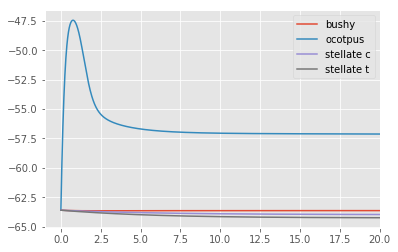

In [12]:
plot(t_vec, v_vecb, label='bushy')
plot(t_vec,v_veco, label='ocotpus')
plot(t_vec, v_vecsc, label='stellate c')
plot(t_vec, v_vecst, label='stellate t')
legend ()
xlim(-1,20)

In [13]:
def split_ih(seg, eh=-43):
    "split ih to Na and K components"
    v = seg.v
    if seg.gbar_hcno != 0.0:
        gh = seg.thegna_hcno
    if seg.ghbar_ih != 0.0:
        gh = seg.ih.gh
        
    gr = float((seg.ena-eh))/(eh-seg.ek)
    denom = (v*(gr+1) - gr*seg.ek - seg.ena)
    if (abs(v-eh) < 1):
        gnah = gh/(gr + 1)
    else: 
        if seg.gbar_hcno != 0.0:
            gnah = seg.i_hcno/denom
        if seg.ghbar_ih != 0.0:
            gnah = seg.i_ih/denom
    inah = gnah*(v-seg.ena)
    ikh = gr*gnah*(v-seg.ek)
    return inah, ikh

In [14]:
def get_Rin(sec):
    seg = sec(0.5)
    gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
    gkr = seg.ik/(seg.v-seg.ek)
    ghr = seg.i_ih/(seg.v- -43)
    glkr = seg.leak.i/(seg.v -seg.erev_leak)
    Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
    return 1e-6/Ginx 

print '{} \t{}\t| {}\n'.format('Cell-type', 'Rin calculated', 'Rin from RM03')
for n in neurons:
    print '{} : \t{}\t| {} MOhm'.format(n[0].name(), get_Rin(n[0]), n[1]['Rin'])

Cell-type 	Rin calculated	| Rin from RM03

bushy : 	71.0284615279	| 71 MOhm
octopus : 	18.0806941382	| 6.7 MOhm
stellatec : 	473.112169692	| 473 MOhm
stellatet : 	452.143803758	| 453 MOhm


In [15]:
def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3

def pJ2atp(pJ):
    "pJ/s --> ATPs/s"
    return pmol2molecules(nJ2atp(pJ))

In [16]:
def mouj_Erate2_d(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    inah, ikh = split_ih(seg)# раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    
    acc_h = (abs(inah*(v-seg.ena)) + abs(ikh*(v-seg.ek)))*seg.area()*factor
    acc_klt = abs(seg.ik_klt*(v-seg.ek))*seg.area()*factor
    acc_ka = abs(seg.ik_ka*(v-seg.ek))*seg.area()*factor
    
    
    return array([acc*seg.area()*factor, acc_h, acc_klt, acc_ka])

In [17]:
def print_ratp_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    
    mouj_dh, mouj_h_dh, mouj_klt_dh = mouj_Erate2(cell(0.5))
#     mouj_atp = nJ2atp(mouj_dh)
    print "Attwell: %.3e pmol ATP/s"%attw
    print "Moujahid: %.3e pmol ATP/s"%mouj_atp
    print "A:M ratio: %2.3f"%(attw/mouj_atp)
    
def print_erate_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    seg = cell(0.5)
    mouj_set = mouj_Erate2_d(seg)[0]
#     mujpow = seg.erate_mujpow*seg.area()*1e-8
    attw_erate = atp2J(attw)
    print "Attwell: %.3e pJ/s"%attw_erate
    print "Moujahid: %.3e, pJ/s"%(mouj_set)
#     print "Mujpow dummy mech: %.3e pJ/s"%mujpow
    print "A:M ratio: %2.3f"%(attw_erate/mouj_set)

In [18]:
for npx in neurons:
    n = npx[0]
    print '===== ', n.name(), ' ====='
    print_erate_estimate(n)
    #print "Mujpow dummy mechanism: ", n.
    print '------\n'

=====  bushy  =====
Attwell: 2.144e+01 pJ/s
Moujahid: 9.044e+00, pJ/s
A:M ratio: 2.371
------

=====  octopus  =====
Attwell: 1.404e+02 pJ/s
Moujahid: 1.150e+02, pJ/s
A:M ratio: 1.220
------

=====  stellatec  =====
Attwell: 3.072e+00 pJ/s
Moujahid: 3.086e-01, pJ/s
A:M ratio: 9.954
------

=====  stellatet  =====
Attwell: 3.084e+00 pJ/s
Moujahid: 3.127e-01, pJ/s
A:M ratio: 9.863
------



In [19]:
def collect_MoujErates(neurons):
    Mes = dict()
    for npx in neurons:
        Mes[npx[0].name()] = pJ2atp(mouj_Erate2_d(npx[0](.5)))/1e9 # total, ih, ikl, ika (Units: 1e9 ATPs/s)
    return Mes

Mes = collect_MoujErates(neurons)
Mes = pandas.DataFrame(Mes,index=['Total','g$_h$','g$_{Klt}$','g$_{A}$']).T

In [20]:
Mes

,Total,g$_h$,g$_{Klt}$,g$_{A}$
bushy,0.108928,0.103315,0.004459,0.000000
octopus,1.385559,1.297766,0.082196,0.000000
stellatec,0.003717,0.002691,0.000000,0.000000
stellatet,0.003766,0.002789,0.000000,0.000045


In [21]:
# make 'Other' instead of 'Total'
Mes.Total = Mes.Total -Mes['g$_h$'] -Mes['g$_{Klt}$'] -Mes['g$_{A}$'] 
Mes = Mes.rename(index={'bushy':'BC','octopus':'OC','stellatet':'SC'}, columns={'Total':'Other'})
# pop SC-c cells out
Mes=Mes.drop(['stellatec'])

In [22]:
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

/Users/lampochka/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


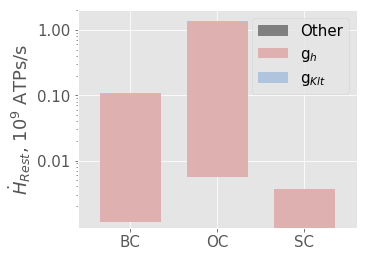

In [23]:
fig,ax = subplots(figsize=(5,4))
# Mes.plot.bar(stacked=True,color=['grey','#deb0b0','#b0c4de', 'm'],width=0.7,rot=0,ax=ax)
Mes[['Other','g$_h$','g$_{Klt}$']].plot.bar(stacked=True,color=['grey','#deb0b0','#b0c4de'],width=0.7,rot=0,ax=ax)

yscale('log')
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('$\dot{H}_{Rest}$, $10^9$ ATPs/s')
ax.yaxis.set_ticks([0.01,0.1,1.0])
# tight_layout()
# savefig('Point-models-resting-energy.pdf') # Inkscape used to fix 'Other' part and y-axis name